In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import  auc,classification_report,precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [31]:
df_test.shape

(200000, 201)

([<matplotlib.patches.Wedge at 0x25b61ff7e90>,
 [Text(-1.045637701821428, 0.34152861743871876, '0'),
  Text(1.0456377316788052, -0.3415285260261626, '1')],
 [Text(-0.5703478373571425, 0.18628833678475568, '90.0%'),
  Text(0.5703478536429846, -0.1862882869233614, '10.0%')])

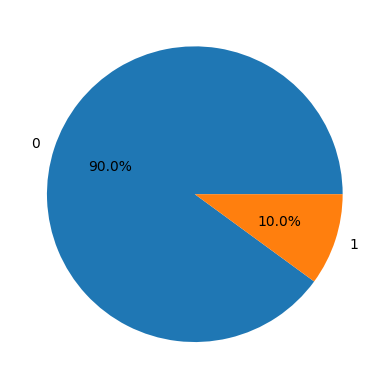

In [32]:
plt.pie(df['target'].value_counts(), labels=df['target'].value_counts().index, autopct='%1.1f%%')

In [3]:
x=df.iloc[:,2:]
y=df.iloc[:,1]
df_test_x=df_test.iloc[:,1:]

In [4]:
corr_matrix = df.iloc[:, 1:].corr()
np.fill_diagonal(corr_matrix.values, 0)
max_corr_values = np.max(np.abs(corr_matrix.values), axis=1)
low_corr_features = corr_matrix.index[max_corr_values < 0.008].tolist()
len(low_corr_features)

31

In [5]:
x.drop(low_corr_features,axis=1,inplace=True)
df_test_x.drop(low_corr_features,axis=1,inplace=True)
x.shape

(200000, 169)

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)
x_train.shape

(140000, 169)

In [7]:
print(np.unique(y_test,return_counts=True))

(array([0, 1]), array([53971,  6029]))


In [7]:
#handeling imbalanced dataset
#50%rus/50%ros:
x_train_under,x_train_over,y_train_under,y_train_over=train_test_split(x_train,y_train,test_size=0.5,random_state=42,stratify=y_train)
rus=RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus=rus.fit_resample(x_train_under,y_train_under)
smote = SMOTE(random_state=42)
x_train_smt, y_train_smt = smote.fit_resample(x_train_over, y_train_over)
x_train_bal = np.concatenate((x_train_rus, x_train_smt), axis=0)
y_train_bal = np.concatenate((y_train_rus, y_train_smt), axis=0)
x_train_bal.shape

(140002, 169)

In [8]:
sc=StandardScaler()
x_train_bal_sc=sc.fit_transform(x_train_bal)
x_test_sc=sc.transform(x_test)

c:\Users\User\Desktop\MLtasks\env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [35]:
log1=LogisticRegression(max_iter=100,random_state=42)
log1.fit(x_train_bal_sc, y_train_bal)
y_pred=log1.predict(x_test_sc)
log1.score(x_train_bal_sc, y_train_bal),log1.score(x_test_sc,y_test)

(0.7963814802645677, 0.7877)

In [10]:
#pov:for this problem fp costs more than fn ,so i prefer to have higher percision score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     53971
           1       0.29      0.76      0.42      6029

    accuracy                           0.79     60000
   macro avg       0.63      0.78      0.64     60000
weighted avg       0.90      0.79      0.82     60000



In [11]:
y_prob = log1.predict_proba(x_test_sc)[:, 1] 

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

np.float64(0.7713396955632194)

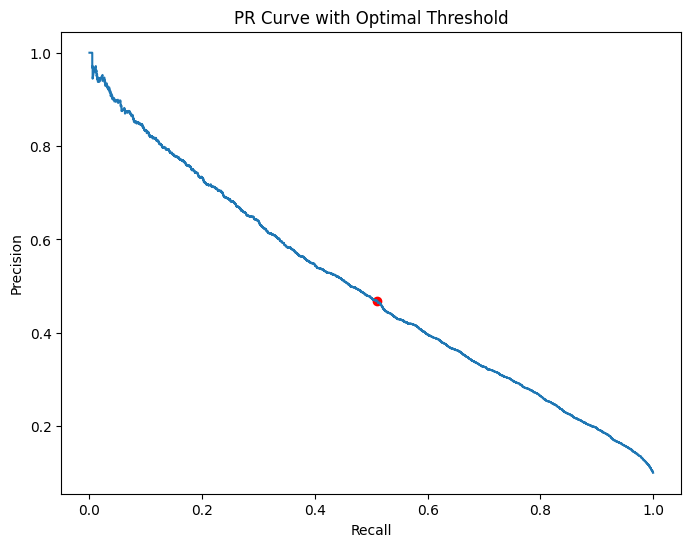

0.4941105170552522


In [13]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.scatter(recall[optimal_idx], precision[optimal_idx], color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve with Optimal Threshold")
plt.show()
print(auc(recall, precision))

to have higher percision score we can use threshold>optimal threshold

In [14]:
y_pred_new = (y_prob >= optimal_threshold).astype(int)#highest f1
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     53971
           1       0.47      0.51      0.49      6029

    accuracy                           0.89     60000
   macro avg       0.71      0.72      0.71     60000
weighted avg       0.90      0.89      0.89     60000



In [16]:
target=log1.predict(df_test_x)
df_test['target']=target


c:\Users\User\Desktop\MLtasks\env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
